## Imports

In [261]:
import torch
from torch import nn
from torch import Tensor
import torch.optim as optim
from torchvision import models, transforms, datasets
from tqdm import tqdm

torch.cuda.is_available()

True

In [262]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import cv2
import shutil

In [263]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Visualize the data

In [264]:
def plot_accuracy_from_history(*histories, labels=None) -> None:
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots

    for i, history in enumerate(histories):
        epochs = np.arange(1, len(history['accuracy']) + 1)
        
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        
        plt.plot(epochs, acc, color + 'o', label=f'Training accuracy for {label}')
        plt.plot(epochs, val_acc, color, label=f'Validation accuracy for {label}')

# Transfer Learning

## Prepare Data

In [265]:
EPOCHS: int = 60

In [266]:

kaggle_dir = "flowers"
    
processed_dir = kaggle_dir + "/processed"
flowers_dir = processed_dir + ""
base_dir = flowers_dir + "/"

train_dir: str = base_dir + "train/"
train_daisy_dir: str = train_dir + "daisy/"
train_dandelion_dir: str = train_dir + "dandelion/"
train_rose_dir: str = train_dir + "rose/"
train_sunflower_dir: str = train_dir + "sunflower/"
train_tulip_dir: str = train_dir + "tulip/"

validation_dir: str = base_dir + "validation/"
validation_daisy_dir: str = validation_dir + "daisy/"
validation_dandelion_dir: str = validation_dir + "dandelion/"
validation_rose_dir: str = validation_dir + "rose/"
validation_sunflower_dir: str = validation_dir + "sunflower/"
validation_tulip_dir: str = validation_dir + "tulip/"

test_dir: str = base_dir + "test/"
test_daisy_dir: str = test_dir + "daisy/"
test_dandelion_dir: str = test_dir + "dandelion/"
test_rose_dir: str = test_dir + "rose/"
test_sunflower_dir: str = test_dir + "sunflower/"
test_tulip_dir: str = test_dir + "tulip/"

models_dir: str = "models/"

def create_dirs() -> None:
    all_paths: list[str] = [kaggle_dir, processed_dir, flowers_dir,
                            base_dir, train_dir, train_daisy_dir, train_dandelion_dir, train_rose_dir, train_sunflower_dir, train_tulip_dir, validation_dir, validation_daisy_dir, validation_dandelion_dir, validation_rose_dir, validation_sunflower_dir, validation_tulip_dir, test_dir, test_daisy_dir, test_dandelion_dir, test_rose_dir, test_sunflower_dir, test_tulip_dir, models_dir]
    # create dirs if not exist
    for path in all_paths:
        if not os.path.exists(path):
            os.makedirs(path)

def copy_train_images(indices: np.ndarray, animal: str ='cat', dir_type: str ='train') -> None:
    for index in indices:
        src: str = f"{kaggle_dir}/original/train/{animal}.{index}.jpg"
        dst: str = f"{kaggle_dir}/processed/flowers/{dir_type}/{animal}s/{animal}.{index}.jpg"
        shutil.copyfile(src, dst)

def remove_images():
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir, ignore_errors=True)

def copy_all_images(validation_size_ratio = 0.1, test_size_ratio = 0.1) -> None:
    remove_images()

    create_dirs()
    print("Dirs created")
    
    directories: list[str] = os.listdir("kaggle/flowers/original/train")
    
    print("Dirs listed")

    for directory in directories:
        if not os.path.exists(f"{base_dir}train/{directory}"):
            os.makedirs(f"{base_dir}train/{directory}")
        if not os.path.exists(f"{base_dir}validation/{directory}"):
            os.makedirs(f"{base_dir}validation/{directory}")
        if not os.path.exists(f"{base_dir}test/{directory}"):
            os.makedirs(f"{base_dir}test/{directory}")
            
    print("Dirs created")
            
    for directory in directories:
        files = glob.glob(f"kaggle/flowers/original/train/{directory}/*.jpg")
        
        total_size = len(files)
        
        validation_size = int(total_size * validation_size_ratio)
        test_size = int(total_size * test_size_ratio)
        train_size = total_size - validation_size - test_size
        
        np.random.shuffle(files)
        
        train_files = files[:train_size]
        validation_files = files[train_size:train_size + validation_size]
        test_files = files[train_size + validation_size:]
        
        for file in train_files:
            shutil.copy(file, f"{base_dir}train/{directory}/")
        for file in validation_files:
            shutil.copy(file, f"{base_dir}validation/{directory}/")
        for file in test_files:
            shutil.copy(file, f"{base_dir}test/{directory}/")
    
    print("Images copied")

In [267]:
copy_all_images()

Dirs created
Dirs listed
Dirs created
Images copied


In [268]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Define data directories
data_dir: str = 'flowers/processed/'
image_datasets = {x: datasets.ImageFolder(root=data_dir+x, transform=data_transforms[x]) for x in ['train', 'validation', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=20, shuffle=False) for x in ['train', 'validation', 'test']}


In [269]:
COUNT_OF_CLASSES = len(image_datasets['train'].classes)
print(COUNT_OF_CLASSES)

5


## Features Extraction Method (caching ResNet so faster but no augmentation)

### Define ResNet Model

In [270]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final fully connected layer

    def forward(self, x):
        x = self.resnet(x)
        return x

### Extract features from ResNet

In [271]:
def extract_features(model, dataloader, dataset_size) -> tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    features = torch.zeros(dataset_size, 512, 4, 4, device=device)
    labels = torch.zeros(dataset_size, device=device)
    with torch.no_grad():
        for i, (inputs, labels_batch) in enumerate(dataloader):
            inputs = inputs.to(device)  # Move inputs to the same device as the model
            outputs = model(inputs)
            # Reshape or unsqueeze outputs to match the shape of features
            outputs = torch.unsqueeze(torch.unsqueeze(outputs, -1), -1)
            features[i * dataloader.batch_size : (i + 1) * dataloader.batch_size] = outputs
            labels[i * dataloader.batch_size : (i + 1) * dataloader.batch_size] = labels_batch
    return features, labels

In [272]:
resnet_model = ResNetModel().to(device)

train_features, train_labels = extract_features(resnet_model, dataloaders['train'], len(image_datasets['train']))
validation_features, validation_labels = extract_features(resnet_model, dataloaders['validation'], len(image_datasets['validation']))
test_features, test_labels = extract_features(resnet_model, dataloaders['test'], len(image_datasets['test']))

# Reshape
train_features = train_features.view(len(image_datasets['train']), -1)
validation_features = validation_features.view(len(image_datasets['validation']), -1)
test_features = test_features.view(len(image_datasets['test']), -1)

print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

/home/lenovo/Proj/DeepNeuralNetworks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lenovo/Proj/DeepNeuralNetworks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1831, 8192])
torch.Size([226, 8192])
torch.Size([226, 8192])


In [273]:
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
validation_dataset = torch.utils.data.TensorDataset(validation_features, validation_labels)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True)

### New model

In [274]:
class ModelWithExtracted(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(train_features.shape[1], 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, COUNT_OF_CLASSES)
        )

    def forward(self, x):
        x = self.model(x)
        return x

### Train

In [275]:
model1 = ModelWithExtracted().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

def train_model(model, criterion, optimizer) -> None:
    accuracy_history: list = []
    loss_history: list = []
    val_accuracy_history: list = []
    val_loss_history: list = []
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.long().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels)
        epoch_loss = running_loss / len(image_datasets['train'])
        epoch_acc = running_corrects / len(image_datasets['train'])
        accuracy_history.append(epoch_acc)
        loss_history.append(epoch_loss)
        
        inputs_val, labels_val = next(iter(validation_loader))
        with torch.no_grad():
            model.eval()
            inputs_val = inputs_val.to(device)
            labels_val = labels_val.long().to(device)
            val_outputs = model(inputs_val)
            val_loss = criterion(val_outputs, labels_val)
            val_preds = torch.round(val_outputs)
            val_acc = torch.sum(torch.argmax(val_preds, 1) == labels_val).item() / len(labels_val)
            val_accuracy_history.append(val_acc)
            val_loss_history.append(val_loss)
        
            print(f"Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            print(f"Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    history = {
        'accuracy': accuracy_history,
        'loss': loss_history,
        'val_accuracy': val_accuracy_history,
        'val_loss': val_loss_history
    }
    return history
        
history1 = train_model(model1, criterion, optimizer)

  0%|          | 0/92 [00:00<?, ?it/s]

100%|██████████| 92/92 [00:00<00:00, 207.26it/s]


Epoch 1/60 Loss: 0.7162 Acc: 0.7351
Validation Loss: 0.3819 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 205.03it/s]


Epoch 2/60 Loss: 0.4055 Acc: 0.8542
Validation Loss: 0.5357 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 208.85it/s]


Epoch 3/60 Loss: 0.2901 Acc: 0.9033
Validation Loss: 0.1428 Acc: 1.0000


100%|██████████| 92/92 [00:00<00:00, 208.73it/s]


Epoch 4/60 Loss: 0.2005 Acc: 0.9235
Validation Loss: 0.3485 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 233.37it/s]


Epoch 5/60 Loss: 0.1736 Acc: 0.9388
Validation Loss: 1.0411 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 201.06it/s]


Epoch 6/60 Loss: 0.1751 Acc: 0.9410
Validation Loss: 0.4130 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 220.75it/s]


Epoch 7/60 Loss: 0.1428 Acc: 0.9487
Validation Loss: 0.5185 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 224.65it/s]


Epoch 8/60 Loss: 0.1156 Acc: 0.9590
Validation Loss: 0.6983 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 222.65it/s]


Epoch 9/60 Loss: 0.0794 Acc: 0.9743
Validation Loss: 1.0147 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 216.78it/s]


Epoch 10/60 Loss: 0.1124 Acc: 0.9607
Validation Loss: 0.7796 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 219.19it/s]


Epoch 11/60 Loss: 0.0637 Acc: 0.9776
Validation Loss: 1.3588 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 219.15it/s]


Epoch 12/60 Loss: 0.0951 Acc: 0.9678
Validation Loss: 0.2778 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 217.66it/s]


Epoch 13/60 Loss: 0.0719 Acc: 0.9776
Validation Loss: 0.3013 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 219.12it/s]


Epoch 14/60 Loss: 0.0736 Acc: 0.9743
Validation Loss: 1.1100 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 216.48it/s]


Epoch 15/60 Loss: 0.0285 Acc: 0.9913
Validation Loss: 0.5202 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 219.41it/s]


Epoch 16/60 Loss: 0.0137 Acc: 0.9956
Validation Loss: 1.1285 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 218.19it/s]


Epoch 17/60 Loss: 0.0151 Acc: 0.9940
Validation Loss: 0.1908 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 217.23it/s]


Epoch 18/60 Loss: 0.1342 Acc: 0.9579
Validation Loss: 0.0869 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 217.67it/s]


Epoch 19/60 Loss: 0.0894 Acc: 0.9721
Validation Loss: 0.2104 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 226.43it/s]


Epoch 20/60 Loss: 0.0624 Acc: 0.9803
Validation Loss: 0.0586 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 229.68it/s]


Epoch 21/60 Loss: 0.0532 Acc: 0.9825
Validation Loss: 1.4224 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 221.97it/s]


Epoch 22/60 Loss: 0.0511 Acc: 0.9831
Validation Loss: 0.3986 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 229.17it/s]


Epoch 23/60 Loss: 0.0884 Acc: 0.9749
Validation Loss: 1.3749 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 216.77it/s]


Epoch 24/60 Loss: 0.0715 Acc: 0.9782
Validation Loss: 0.3775 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 218.99it/s]


Epoch 25/60 Loss: 0.0253 Acc: 0.9918
Validation Loss: 1.0406 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 217.50it/s]


Epoch 26/60 Loss: 0.0771 Acc: 0.9782
Validation Loss: 1.1387 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 214.70it/s]


Epoch 27/60 Loss: 0.0143 Acc: 0.9956
Validation Loss: 1.0578 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 218.77it/s]


Epoch 28/60 Loss: 0.0056 Acc: 0.9978
Validation Loss: 0.5750 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 216.96it/s]


Epoch 29/60 Loss: 0.0033 Acc: 0.9995
Validation Loss: 0.2622 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 219.77it/s]


Epoch 30/60 Loss: 0.0026 Acc: 0.9995
Validation Loss: 0.5698 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 216.72it/s]


Epoch 31/60 Loss: 0.0010 Acc: 1.0000
Validation Loss: 2.5090 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 216.34it/s]


Epoch 32/60 Loss: 0.0154 Acc: 0.9967
Validation Loss: 0.6022 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 215.55it/s]


Epoch 33/60 Loss: 0.0555 Acc: 0.9814
Validation Loss: 0.9365 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 219.71it/s]


Epoch 34/60 Loss: 0.1215 Acc: 0.9683
Validation Loss: 0.5711 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 217.60it/s]


Epoch 35/60 Loss: 0.0563 Acc: 0.9836
Validation Loss: 0.3674 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 218.34it/s]


Epoch 36/60 Loss: 0.0107 Acc: 0.9978
Validation Loss: 1.0430 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 218.33it/s]


Epoch 37/60 Loss: 0.0065 Acc: 0.9978
Validation Loss: 1.9472 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 216.20it/s]


Epoch 38/60 Loss: 0.0198 Acc: 0.9929
Validation Loss: 0.7186 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 211.41it/s]


Epoch 39/60 Loss: 0.0272 Acc: 0.9929
Validation Loss: 0.5141 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 199.16it/s]


Epoch 40/60 Loss: 0.0154 Acc: 0.9967
Validation Loss: 0.7549 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 206.53it/s]


Epoch 41/60 Loss: 0.0077 Acc: 0.9973
Validation Loss: 0.3820 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 219.46it/s]


Epoch 42/60 Loss: 0.0515 Acc: 0.9853
Validation Loss: 0.4057 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 217.26it/s]


Epoch 43/60 Loss: 0.0378 Acc: 0.9874
Validation Loss: 0.4884 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 214.24it/s]


Epoch 44/60 Loss: 0.0135 Acc: 0.9945
Validation Loss: 0.3721 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 226.80it/s]


Epoch 45/60 Loss: 0.0081 Acc: 0.9973
Validation Loss: 1.1460 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 214.60it/s]


Epoch 46/60 Loss: 0.0956 Acc: 0.9776
Validation Loss: 1.4016 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 214.75it/s]


Epoch 47/60 Loss: 0.1329 Acc: 0.9601
Validation Loss: 0.2843 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 212.08it/s]


Epoch 48/60 Loss: 0.0731 Acc: 0.9798
Validation Loss: 0.3774 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 217.82it/s]


Epoch 49/60 Loss: 0.0305 Acc: 0.9902
Validation Loss: 0.8469 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 216.57it/s]


Epoch 50/60 Loss: 0.0055 Acc: 0.9989
Validation Loss: 2.1178 Acc: 0.6000


100%|██████████| 92/92 [00:00<00:00, 215.82it/s]


Epoch 51/60 Loss: 0.0057 Acc: 0.9978
Validation Loss: 0.0004 Acc: 1.0000


100%|██████████| 92/92 [00:00<00:00, 213.68it/s]


Epoch 52/60 Loss: 0.0028 Acc: 0.9995
Validation Loss: 0.3669 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 218.78it/s]


Epoch 53/60 Loss: 0.0068 Acc: 0.9978
Validation Loss: 0.5359 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 212.42it/s]


Epoch 54/60 Loss: 0.0385 Acc: 0.9858
Validation Loss: 0.2416 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 210.95it/s]


Epoch 55/60 Loss: 0.0243 Acc: 0.9924
Validation Loss: 1.1589 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 211.31it/s]


Epoch 56/60 Loss: 0.0206 Acc: 0.9934
Validation Loss: 2.0826 Acc: 0.7000


100%|██████████| 92/92 [00:00<00:00, 210.92it/s]


Epoch 57/60 Loss: 0.0191 Acc: 0.9967
Validation Loss: 0.7146 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 211.08it/s]


Epoch 58/60 Loss: 0.0420 Acc: 0.9907
Validation Loss: 1.0257 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 211.93it/s]


Epoch 59/60 Loss: 0.0280 Acc: 0.9924
Validation Loss: 0.1030 Acc: 0.9500


100%|██████████| 92/92 [00:01<00:00, 62.18it/s] 

Epoch 60/60 Loss: 0.0118 Acc: 0.9956
Validation Loss: 0.0003 Acc: 1.0000


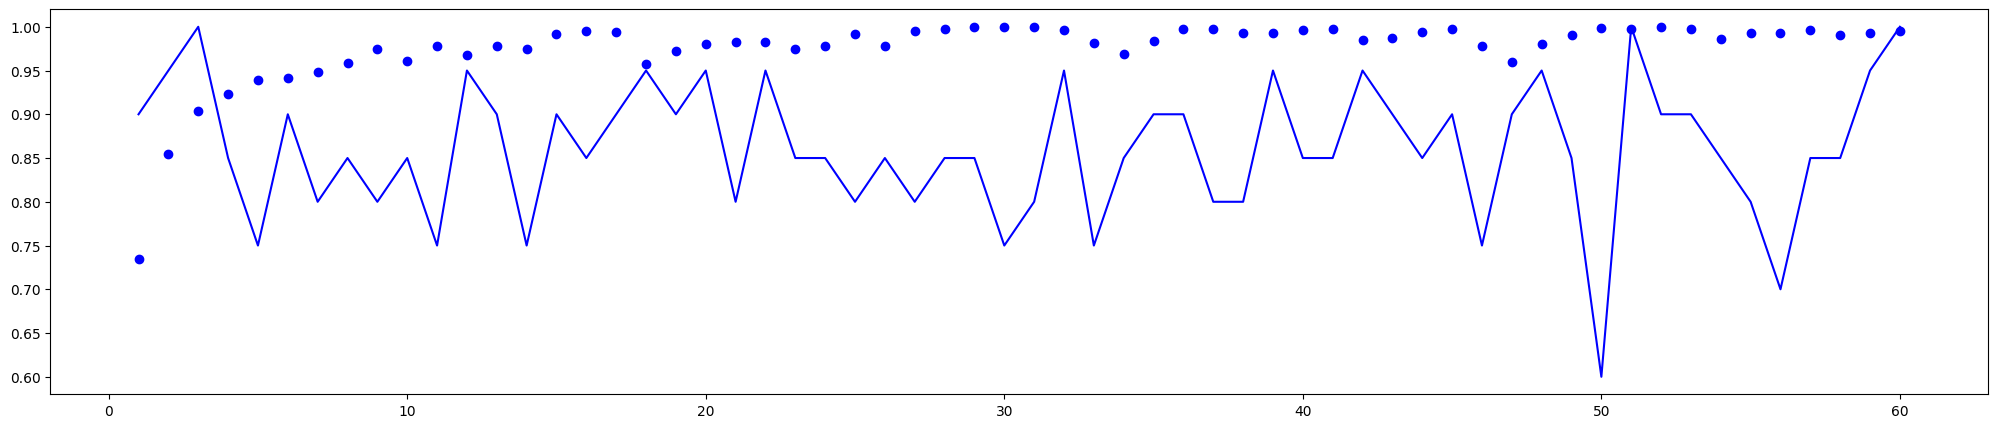

In [276]:
history1 = {k: [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in vs] for k, vs in history1.items()}
plot_accuracy_from_history(history1)

## Fine-Tuning method (slower but with augmentation)

### Prepare Data

In [277]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # random horizontal flip
        transforms.RandomHorizontalFlip(),
        # random Linear Transformation
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    ]),
    'validation': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Define data directories
data_dir: str = 'flowers/processed/'
image_datasets = {x: datasets.ImageFolder(root=data_dir+x, transform=data_transforms[x]) for x in ['train', 'validation', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=20, shuffle=True) for x in ['train', 'validation', 'test']}


In [278]:
COUNT_OF_CLASSES = len(image_datasets['train'].classes)
print(COUNT_OF_CLASSES)

5


### Create model

In [279]:
class ModelFineTuning(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters(): # freeze the ResNet layers
            param.requires_grad = False
        self.resnet.fc = nn.Identity()
        self.model = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, COUNT_OF_CLASSES),
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.model(x)
        return x
    
    
model2 = ModelFineTuning().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [280]:

# Training loop
accuracy_history: list = []
loss_history: list = []
val_accuracy_history: list = []
val_loss_history: list = []

for epoch in range(EPOCHS):
    
    model2.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(dataloaders['train']):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # print(inputs.shape, labels.shape)
        # print(inputs)
        # print(labels)
        
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.cpu().item() * inputs.size(0)
        running_corrects += torch.sum(torch.argmax(outputs, 1) == labels)
    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = running_corrects / len(image_datasets['train'])
    accuracy_history.append(epoch_acc)
    loss_history.append(epoch_loss)

    # Validation loop
    model2.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['validation'], disable=True):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model2(inputs)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.cpu().item() * inputs.size(0)
            val_running_corrects += torch.sum(torch.argmax(outputs, 1) == labels)
    val_epoch_loss = val_running_loss / len(image_datasets['validation'])
    val_epoch_acc = val_running_corrects / len(image_datasets['validation'])
    val_accuracy_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Validation Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
history2: dict = {
        'accuracy': accuracy_history,
        'loss': loss_history,
        'val_accuracy': val_accuracy_history,
        'val_loss': val_loss_history
}
    
    

100%|██████████| 92/92 [00:08<00:00, 10.92it/s]


Epoch 1/60 Loss: 0.9063 Acc: 0.6477
Validation Loss: 0.4821 Acc: 0.8230


100%|██████████| 92/92 [00:07<00:00, 11.94it/s]


Epoch 2/60 Loss: 0.5861 Acc: 0.7941
Validation Loss: 0.4140 Acc: 0.8717


100%|██████████| 92/92 [00:08<00:00, 11.39it/s]


Epoch 3/60 Loss: 0.5156 Acc: 0.8154
Validation Loss: 0.4466 Acc: 0.8319


100%|██████████| 92/92 [00:09<00:00, 10.01it/s]


Epoch 4/60 Loss: 0.4809 Acc: 0.8318
Validation Loss: 0.4105 Acc: 0.8496


100%|██████████| 92/92 [00:07<00:00, 11.71it/s]


Epoch 5/60 Loss: 0.4375 Acc: 0.8400
Validation Loss: 0.3529 Acc: 0.8407


100%|██████████| 92/92 [00:07<00:00, 11.77it/s]


Epoch 6/60 Loss: 0.4365 Acc: 0.8547
Validation Loss: 0.4154 Acc: 0.8319


100%|██████████| 92/92 [00:07<00:00, 11.55it/s]


Epoch 7/60 Loss: 0.4162 Acc: 0.8487
Validation Loss: 0.3385 Acc: 0.8496


100%|██████████| 92/92 [00:09<00:00,  9.70it/s]


Epoch 8/60 Loss: 0.4001 Acc: 0.8547
Validation Loss: 0.3339 Acc: 0.8761


100%|██████████| 92/92 [00:07<00:00, 11.77it/s]


Epoch 9/60 Loss: 0.3718 Acc: 0.8635
Validation Loss: 0.3616 Acc: 0.8628


100%|██████████| 92/92 [00:08<00:00, 11.28it/s]


Epoch 10/60 Loss: 0.3476 Acc: 0.8826
Validation Loss: 0.3016 Acc: 0.8894


100%|██████████| 92/92 [00:08<00:00, 11.31it/s]


Epoch 11/60 Loss: 0.3534 Acc: 0.8733
Validation Loss: 0.3470 Acc: 0.8584


100%|██████████| 92/92 [00:09<00:00,  9.88it/s]


Epoch 12/60 Loss: 0.3931 Acc: 0.8640
Validation Loss: 0.3288 Acc: 0.8761


100%|██████████| 92/92 [00:08<00:00, 10.81it/s]


Epoch 13/60 Loss: 0.3819 Acc: 0.8662
Validation Loss: 0.3206 Acc: 0.8717


100%|██████████| 92/92 [00:08<00:00, 10.76it/s]


Epoch 14/60 Loss: 0.3285 Acc: 0.8771
Validation Loss: 0.3567 Acc: 0.8673


100%|██████████| 92/92 [00:09<00:00,  9.56it/s]


Epoch 15/60 Loss: 0.3206 Acc: 0.8875
Validation Loss: 0.3591 Acc: 0.8584


100%|██████████| 92/92 [00:07<00:00, 11.93it/s]


Epoch 16/60 Loss: 0.3043 Acc: 0.8913
Validation Loss: 0.2990 Acc: 0.8805


100%|██████████| 92/92 [00:07<00:00, 11.65it/s]


Epoch 17/60 Loss: 0.2619 Acc: 0.9050
Validation Loss: 0.3038 Acc: 0.8938


100%|██████████| 92/92 [00:08<00:00, 11.45it/s]


Epoch 18/60 Loss: 0.3032 Acc: 0.8859
Validation Loss: 0.4123 Acc: 0.8540


100%|██████████| 92/92 [00:09<00:00,  9.99it/s]


Epoch 19/60 Loss: 0.3087 Acc: 0.8886
Validation Loss: 0.3225 Acc: 0.8717


100%|██████████| 92/92 [00:07<00:00, 11.65it/s]


Epoch 20/60 Loss: 0.2806 Acc: 0.9055
Validation Loss: 0.3516 Acc: 0.8850


100%|██████████| 92/92 [00:07<00:00, 11.63it/s]


Epoch 21/60 Loss: 0.2551 Acc: 0.9017
Validation Loss: 0.3404 Acc: 0.8850


100%|██████████| 92/92 [00:07<00:00, 11.53it/s]


Epoch 22/60 Loss: 0.2418 Acc: 0.9153
Validation Loss: 0.3767 Acc: 0.8628


100%|██████████| 92/92 [00:08<00:00, 11.44it/s]


Epoch 23/60 Loss: 0.2561 Acc: 0.9066
Validation Loss: 0.3927 Acc: 0.8761


100%|██████████| 92/92 [00:07<00:00, 11.84it/s]


Epoch 24/60 Loss: 0.2644 Acc: 0.9110
Validation Loss: 0.4085 Acc: 0.8540


100%|██████████| 92/92 [00:08<00:00, 11.47it/s]


Epoch 25/60 Loss: 0.2659 Acc: 0.8979
Validation Loss: 0.3821 Acc: 0.8761


100%|██████████| 92/92 [00:09<00:00,  9.67it/s]


Epoch 26/60 Loss: 0.2264 Acc: 0.9224
Validation Loss: 0.4611 Acc: 0.8761


100%|██████████| 92/92 [00:07<00:00, 11.86it/s]


Epoch 27/60 Loss: 0.2610 Acc: 0.9050
Validation Loss: 0.4894 Acc: 0.8363


100%|██████████| 92/92 [00:07<00:00, 11.63it/s]


Epoch 28/60 Loss: 0.2135 Acc: 0.9224
Validation Loss: 0.4422 Acc: 0.8540


100%|██████████| 92/92 [00:08<00:00, 11.47it/s]


Epoch 29/60 Loss: 0.2248 Acc: 0.9170
Validation Loss: 0.4960 Acc: 0.8628


100%|██████████| 92/92 [00:09<00:00, 10.05it/s]


Epoch 30/60 Loss: 0.2568 Acc: 0.9203
Validation Loss: 0.3767 Acc: 0.8717


100%|██████████| 92/92 [00:07<00:00, 11.67it/s]


Epoch 31/60 Loss: 0.2207 Acc: 0.9208
Validation Loss: 0.4018 Acc: 0.8584


100%|██████████| 92/92 [00:08<00:00, 11.49it/s]


Epoch 32/60 Loss: 0.2117 Acc: 0.9241
Validation Loss: 0.3869 Acc: 0.8717


100%|██████████| 92/92 [00:08<00:00, 11.41it/s]


Epoch 33/60 Loss: 0.2148 Acc: 0.9274
Validation Loss: 0.4116 Acc: 0.8540


100%|██████████| 92/92 [00:09<00:00, 10.20it/s]


Epoch 34/60 Loss: 0.2209 Acc: 0.9203
Validation Loss: 0.4062 Acc: 0.8540


100%|██████████| 92/92 [00:07<00:00, 12.04it/s]


Epoch 35/60 Loss: 0.2033 Acc: 0.9230
Validation Loss: 0.4081 Acc: 0.8717


100%|██████████| 92/92 [00:07<00:00, 11.77it/s]


Epoch 36/60 Loss: 0.2301 Acc: 0.9235
Validation Loss: 0.4642 Acc: 0.8628


100%|██████████| 92/92 [00:09<00:00, 10.05it/s]


Epoch 37/60 Loss: 0.2146 Acc: 0.9219
Validation Loss: 0.4293 Acc: 0.8628


100%|██████████| 92/92 [00:07<00:00, 11.79it/s]


Epoch 38/60 Loss: 0.1982 Acc: 0.9317
Validation Loss: 0.4738 Acc: 0.8850


100%|██████████| 92/92 [00:07<00:00, 12.06it/s]


Epoch 39/60 Loss: 0.1932 Acc: 0.9366
Validation Loss: 0.4080 Acc: 0.8938


100%|██████████| 92/92 [00:07<00:00, 11.78it/s]


Epoch 40/60 Loss: 0.2002 Acc: 0.9268
Validation Loss: 0.5130 Acc: 0.8673


100%|██████████| 92/92 [00:09<00:00, 10.12it/s]


Epoch 41/60 Loss: 0.1762 Acc: 0.9377
Validation Loss: 0.4611 Acc: 0.8628


100%|██████████| 92/92 [00:07<00:00, 12.00it/s]


Epoch 42/60 Loss: 0.1811 Acc: 0.9328
Validation Loss: 0.4491 Acc: 0.8673


100%|██████████| 92/92 [00:07<00:00, 11.67it/s]


Epoch 43/60 Loss: 0.1757 Acc: 0.9432
Validation Loss: 0.4634 Acc: 0.8496


100%|██████████| 92/92 [00:07<00:00, 11.72it/s]


Epoch 44/60 Loss: 0.2013 Acc: 0.9241
Validation Loss: 0.3999 Acc: 0.8628


100%|██████████| 92/92 [00:09<00:00, 10.16it/s]


Epoch 45/60 Loss: 0.1809 Acc: 0.9323
Validation Loss: 0.4594 Acc: 0.8673


100%|██████████| 92/92 [00:07<00:00, 12.05it/s]


Epoch 46/60 Loss: 0.1718 Acc: 0.9388
Validation Loss: 0.4016 Acc: 0.8850


100%|██████████| 92/92 [00:07<00:00, 11.81it/s]


Epoch 47/60 Loss: 0.1586 Acc: 0.9432
Validation Loss: 0.4604 Acc: 0.8673


100%|██████████| 92/92 [00:08<00:00, 11.46it/s]


Epoch 48/60 Loss: 0.1686 Acc: 0.9394
Validation Loss: 0.4231 Acc: 0.8805


100%|██████████| 92/92 [00:09<00:00,  9.59it/s]


Epoch 49/60 Loss: 0.1613 Acc: 0.9459
Validation Loss: 0.4793 Acc: 0.8628


100%|██████████| 92/92 [00:09<00:00,  9.96it/s]


Epoch 50/60 Loss: 0.1534 Acc: 0.9470
Validation Loss: 0.4809 Acc: 0.8407


100%|██████████| 92/92 [00:09<00:00,  9.64it/s]


Epoch 51/60 Loss: 0.1751 Acc: 0.9399
Validation Loss: 0.4558 Acc: 0.8805


100%|██████████| 92/92 [00:10<00:00,  8.58it/s]


Epoch 52/60 Loss: 0.1372 Acc: 0.9476
Validation Loss: 0.3720 Acc: 0.8850


100%|██████████| 92/92 [00:09<00:00,  9.94it/s]


Epoch 53/60 Loss: 0.1754 Acc: 0.9427
Validation Loss: 0.5245 Acc: 0.8673


100%|██████████| 92/92 [00:09<00:00,  9.75it/s]


Epoch 54/60 Loss: 0.1462 Acc: 0.9525
Validation Loss: 0.4262 Acc: 0.8850


100%|██████████| 92/92 [00:10<00:00,  8.55it/s]


Epoch 55/60 Loss: 0.1647 Acc: 0.9470
Validation Loss: 0.5067 Acc: 0.8584


100%|██████████| 92/92 [00:09<00:00,  9.89it/s]


Epoch 56/60 Loss: 0.1589 Acc: 0.9437
Validation Loss: 0.4107 Acc: 0.8628


100%|██████████| 92/92 [00:09<00:00,  9.66it/s]


Epoch 57/60 Loss: 0.1599 Acc: 0.9481
Validation Loss: 0.4955 Acc: 0.8673


100%|██████████| 92/92 [00:10<00:00,  8.65it/s]


Epoch 58/60 Loss: 0.1496 Acc: 0.9476
Validation Loss: 0.4264 Acc: 0.8850


100%|██████████| 92/92 [00:09<00:00, 10.04it/s]


Epoch 59/60 Loss: 0.1533 Acc: 0.9459
Validation Loss: 0.4874 Acc: 0.8540


100%|██████████| 92/92 [00:09<00:00,  9.85it/s]


Epoch 60/60 Loss: 0.1492 Acc: 0.9487
Validation Loss: 0.3943 Acc: 0.8717


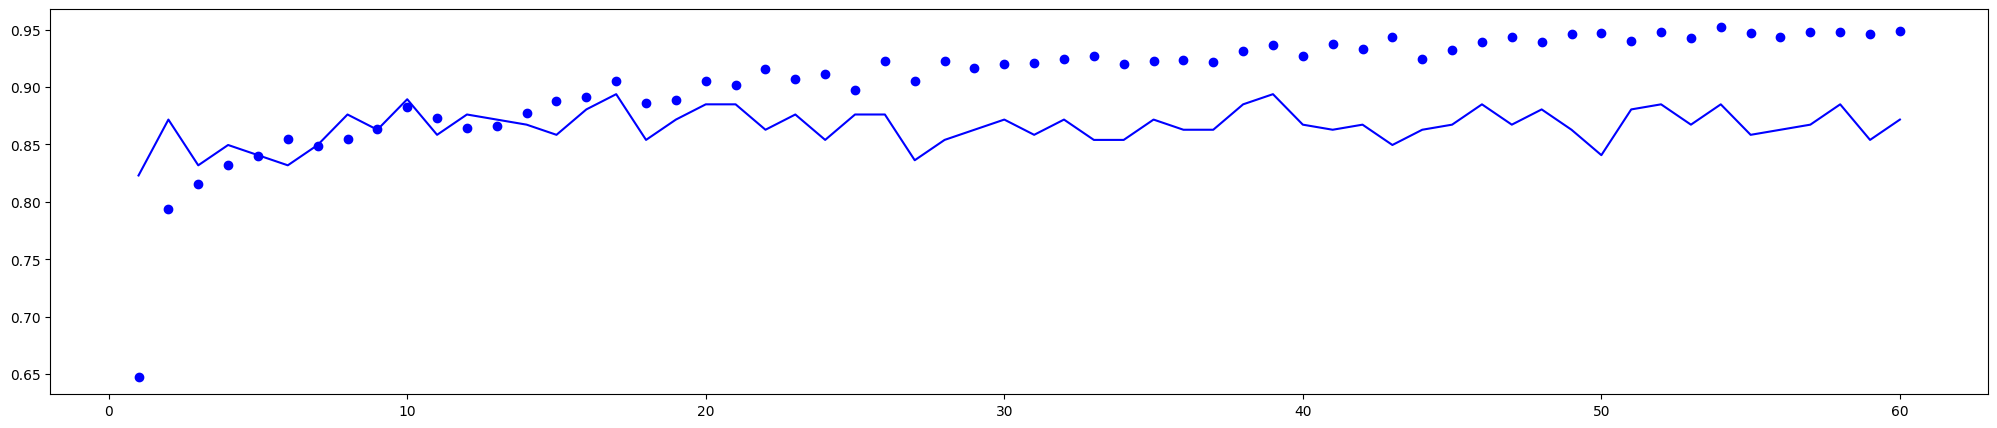

In [281]:
history2 = {k: [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in vs] for k, vs in history2.items()}
plot_accuracy_from_history(history2)

# Tuning Method (unfreeze few layers from ResNet)

In [282]:
class ModelTuning(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters(): # freeze the ResNet layers
            param.requires_grad = False
        for param in self.resnet.layer4.parameters(): # unfreeze the last layer
            param.requires_grad = True
        self.resnet.fc = nn.Identity()
        self.model = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, COUNT_OF_CLASSES),
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.model(x)
        return x
    
    
model3 = ModelTuning().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

In [283]:
accuracy_history: list = []
loss_history: list = []
val_accuracy_history: list = []
val_loss_history: list = []

for epoch in range(EPOCHS):
    model3.train()
    
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(dataloaders['train']):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model3(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.cpu().item() * inputs.size(0)
        running_corrects += torch.sum(torch.argmax(outputs, 1) == labels)
    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = running_corrects / len(image_datasets['train'])
    accuracy_history.append(epoch_acc)
    loss_history.append(epoch_loss)

    # Validation loop
    model3.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['validation'], disable=True):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model3(inputs)
            val_loss = criterion(outputs, labels.long())
            val_running_loss += val_loss.cpu().item() * inputs.size(0)
            val_running_corrects += torch.sum(torch.argmax(outputs, 1) == labels)
    val_epoch_loss = val_running_loss / len(image_datasets['validation'])
    val_epoch_acc = val_running_corrects / len(image_datasets['validation'])
    val_accuracy_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Validation Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
history3: dict = {
        'accuracy': accuracy_history,
        'loss': loss_history,
        'val_accuracy': val_accuracy_history,
        'val_loss': val_loss_history
    }

100%|██████████| 92/92 [00:11<00:00,  8.15it/s]


Epoch 1/60 Loss: 0.6919 Acc: 0.7662
Validation Loss: 0.6724 Acc: 0.7743


100%|██████████| 92/92 [00:09<00:00,  9.73it/s]


Epoch 2/60 Loss: 0.4382 Acc: 0.8624
Validation Loss: 0.3392 Acc: 0.8584


100%|██████████| 92/92 [00:09<00:00,  9.56it/s]


Epoch 3/60 Loss: 0.3346 Acc: 0.8908
Validation Loss: 0.2999 Acc: 0.8938


100%|██████████| 92/92 [00:10<00:00,  8.39it/s]


Epoch 4/60 Loss: 0.2868 Acc: 0.9148
Validation Loss: 0.2893 Acc: 0.9027


100%|██████████| 92/92 [00:09<00:00,  9.62it/s]


Epoch 5/60 Loss: 0.2369 Acc: 0.9285
Validation Loss: 0.3364 Acc: 0.9115


100%|██████████| 92/92 [00:09<00:00,  9.57it/s]


Epoch 6/60 Loss: 0.2740 Acc: 0.9175
Validation Loss: 0.3815 Acc: 0.8805


100%|██████████| 92/92 [00:09<00:00,  9.39it/s]


Epoch 7/60 Loss: 0.2379 Acc: 0.9246
Validation Loss: 0.2339 Acc: 0.9204


100%|██████████| 92/92 [00:09<00:00,  9.64it/s]


Epoch 8/60 Loss: 0.2094 Acc: 0.9372
Validation Loss: 0.2179 Acc: 0.9248


100%|██████████| 92/92 [00:09<00:00,  9.47it/s]


Epoch 9/60 Loss: 0.1551 Acc: 0.9448
Validation Loss: 0.2988 Acc: 0.9248


100%|██████████| 92/92 [00:09<00:00,  9.65it/s]


Epoch 10/60 Loss: 0.1625 Acc: 0.9481
Validation Loss: 0.3303 Acc: 0.9027


100%|██████████| 92/92 [00:10<00:00,  8.60it/s]


Epoch 11/60 Loss: 0.1264 Acc: 0.9596
Validation Loss: 0.4448 Acc: 0.8761


100%|██████████| 92/92 [00:09<00:00,  9.53it/s]


Epoch 12/60 Loss: 0.1434 Acc: 0.9547
Validation Loss: 0.2507 Acc: 0.9204


100%|██████████| 92/92 [00:09<00:00,  9.54it/s]


Epoch 13/60 Loss: 0.1167 Acc: 0.9656
Validation Loss: 0.2939 Acc: 0.9204


100%|██████████| 92/92 [00:10<00:00,  8.59it/s]


Epoch 14/60 Loss: 0.1333 Acc: 0.9569
Validation Loss: 0.2644 Acc: 0.9027


100%|██████████| 92/92 [00:09<00:00,  9.64it/s]


Epoch 15/60 Loss: 0.0941 Acc: 0.9716
Validation Loss: 0.3696 Acc: 0.9071


100%|██████████| 92/92 [00:09<00:00,  9.59it/s]


Epoch 16/60 Loss: 0.0967 Acc: 0.9716
Validation Loss: 0.3512 Acc: 0.8938


100%|██████████| 92/92 [00:10<00:00,  8.60it/s]


Epoch 17/60 Loss: 0.0888 Acc: 0.9721
Validation Loss: 0.3466 Acc: 0.9292


100%|██████████| 92/92 [00:08<00:00, 10.67it/s]


Epoch 18/60 Loss: 0.1172 Acc: 0.9694
Validation Loss: 0.2950 Acc: 0.9115


100%|██████████| 92/92 [00:08<00:00, 10.78it/s]


Epoch 19/60 Loss: 0.0768 Acc: 0.9749
Validation Loss: 0.3504 Acc: 0.9115


100%|██████████| 92/92 [00:09<00:00,  9.55it/s]


Epoch 20/60 Loss: 0.1130 Acc: 0.9683
Validation Loss: 0.4646 Acc: 0.9071


100%|██████████| 92/92 [00:08<00:00, 10.78it/s]


Epoch 21/60 Loss: 0.0769 Acc: 0.9792
Validation Loss: 0.3275 Acc: 0.9248


100%|██████████| 92/92 [00:08<00:00, 10.66it/s]


Epoch 22/60 Loss: 0.0855 Acc: 0.9771
Validation Loss: 0.3110 Acc: 0.9292


100%|██████████| 92/92 [00:08<00:00, 10.73it/s]


Epoch 23/60 Loss: 0.0378 Acc: 0.9891
Validation Loss: 0.4384 Acc: 0.9115


100%|██████████| 92/92 [00:09<00:00,  9.50it/s]


Epoch 24/60 Loss: 0.0659 Acc: 0.9782
Validation Loss: 0.4693 Acc: 0.8982


100%|██████████| 92/92 [00:08<00:00, 10.83it/s]


Epoch 25/60 Loss: 0.0582 Acc: 0.9831
Validation Loss: 0.2618 Acc: 0.9204


100%|██████████| 92/92 [00:08<00:00, 10.82it/s]


Epoch 26/60 Loss: 0.0514 Acc: 0.9831
Validation Loss: 0.2876 Acc: 0.9027


100%|██████████| 92/92 [00:09<00:00,  9.47it/s]


Epoch 27/60 Loss: 0.0571 Acc: 0.9836
Validation Loss: 0.3072 Acc: 0.9115


100%|██████████| 92/92 [00:08<00:00, 10.70it/s]


Epoch 28/60 Loss: 0.0398 Acc: 0.9885
Validation Loss: 0.4026 Acc: 0.8982


100%|██████████| 92/92 [00:08<00:00, 10.74it/s]


Epoch 29/60 Loss: 0.0847 Acc: 0.9771
Validation Loss: 0.2578 Acc: 0.9292


100%|██████████| 92/92 [00:08<00:00, 10.73it/s]


Epoch 30/60 Loss: 0.0509 Acc: 0.9836
Validation Loss: 0.4188 Acc: 0.9115


100%|██████████| 92/92 [00:09<00:00,  9.53it/s]


Epoch 31/60 Loss: 0.0655 Acc: 0.9787
Validation Loss: 0.3212 Acc: 0.9159


100%|██████████| 92/92 [00:08<00:00, 10.66it/s]


Epoch 32/60 Loss: 0.0597 Acc: 0.9831
Validation Loss: 0.3651 Acc: 0.9336


100%|██████████| 92/92 [00:08<00:00, 10.62it/s]


Epoch 33/60 Loss: 0.0524 Acc: 0.9896
Validation Loss: 0.2824 Acc: 0.9115


100%|██████████| 92/92 [00:09<00:00,  9.48it/s]


Epoch 34/60 Loss: 0.0456 Acc: 0.9874
Validation Loss: 0.2868 Acc: 0.9204


100%|██████████| 92/92 [00:08<00:00, 10.62it/s]


Epoch 35/60 Loss: 0.0545 Acc: 0.9825
Validation Loss: 0.3391 Acc: 0.8938


100%|██████████| 92/92 [00:08<00:00, 10.78it/s]


Epoch 36/60 Loss: 0.0285 Acc: 0.9913
Validation Loss: 0.3538 Acc: 0.9115


100%|██████████| 92/92 [00:08<00:00, 10.53it/s]


Epoch 37/60 Loss: 0.0642 Acc: 0.9836
Validation Loss: 0.3502 Acc: 0.9071


100%|██████████| 92/92 [00:09<00:00,  9.54it/s]


Epoch 38/60 Loss: 0.1049 Acc: 0.9727
Validation Loss: 0.3437 Acc: 0.9159


100%|██████████| 92/92 [00:09<00:00,  9.82it/s]


Epoch 39/60 Loss: 0.0399 Acc: 0.9874
Validation Loss: 0.4640 Acc: 0.8938


100%|██████████| 92/92 [00:09<00:00, 10.02it/s]


Epoch 40/60 Loss: 0.0390 Acc: 0.9885
Validation Loss: 0.4430 Acc: 0.9248


100%|██████████| 92/92 [00:10<00:00,  9.06it/s]


Epoch 41/60 Loss: 0.0601 Acc: 0.9814
Validation Loss: 0.2909 Acc: 0.9336


100%|██████████| 92/92 [00:09<00:00,  9.21it/s]


Epoch 42/60 Loss: 0.0564 Acc: 0.9814
Validation Loss: 0.3765 Acc: 0.9115


100%|██████████| 92/92 [00:10<00:00,  8.97it/s]


Epoch 43/60 Loss: 0.0273 Acc: 0.9918
Validation Loss: 0.4201 Acc: 0.9292


100%|██████████| 92/92 [00:22<00:00,  4.03it/s]


Epoch 44/60 Loss: 0.0441 Acc: 0.9858
Validation Loss: 0.3642 Acc: 0.9071


100%|██████████| 92/92 [00:15<00:00,  5.99it/s]


Epoch 45/60 Loss: 0.0573 Acc: 0.9825
Validation Loss: 0.5062 Acc: 0.9071


100%|██████████| 92/92 [00:09<00:00,  9.77it/s]


Epoch 46/60 Loss: 0.0548 Acc: 0.9853
Validation Loss: 0.2846 Acc: 0.9115


100%|██████████| 92/92 [00:08<00:00, 10.36it/s]


Epoch 47/60 Loss: 0.0367 Acc: 0.9896
Validation Loss: 0.5150 Acc: 0.9115


100%|██████████| 92/92 [00:10<00:00,  9.01it/s]


Epoch 48/60 Loss: 0.0445 Acc: 0.9858
Validation Loss: 0.3896 Acc: 0.9292


100%|██████████| 92/92 [00:09<00:00,  9.65it/s]


Epoch 49/60 Loss: 0.0616 Acc: 0.9836
Validation Loss: 0.3971 Acc: 0.9115


100%|██████████| 92/92 [00:08<00:00, 10.46it/s]


Epoch 50/60 Loss: 0.0427 Acc: 0.9902
Validation Loss: 0.4394 Acc: 0.8894


100%|██████████| 92/92 [00:09<00:00,  9.89it/s]


Epoch 51/60 Loss: 0.0327 Acc: 0.9907
Validation Loss: 0.3454 Acc: 0.9115


100%|██████████| 92/92 [00:09<00:00,  9.37it/s]


Epoch 52/60 Loss: 0.0389 Acc: 0.9874
Validation Loss: 0.3703 Acc: 0.9071


100%|██████████| 92/92 [00:08<00:00, 10.95it/s]


Epoch 53/60 Loss: 0.0321 Acc: 0.9940
Validation Loss: 0.3993 Acc: 0.9115


100%|██████████| 92/92 [00:08<00:00, 10.53it/s]


Epoch 54/60 Loss: 0.0441 Acc: 0.9874
Validation Loss: 0.3603 Acc: 0.9292


100%|██████████| 92/92 [00:09<00:00,  9.66it/s]


Epoch 55/60 Loss: 0.0548 Acc: 0.9891
Validation Loss: 0.4640 Acc: 0.9027


100%|██████████| 92/92 [00:08<00:00, 10.94it/s]


Epoch 56/60 Loss: 0.0309 Acc: 0.9913
Validation Loss: 0.3402 Acc: 0.9159


100%|██████████| 92/92 [00:08<00:00, 10.95it/s]


Epoch 57/60 Loss: 0.0388 Acc: 0.9874
Validation Loss: 0.3836 Acc: 0.9204


100%|██████████| 92/92 [00:08<00:00, 10.93it/s]


Epoch 58/60 Loss: 0.0303 Acc: 0.9913
Validation Loss: 0.4475 Acc: 0.9115


100%|██████████| 92/92 [00:09<00:00,  9.54it/s]


Epoch 59/60 Loss: 0.0391 Acc: 0.9891
Validation Loss: 0.6104 Acc: 0.8717


100%|██████████| 92/92 [00:08<00:00, 10.27it/s]


Epoch 60/60 Loss: 0.0353 Acc: 0.9907
Validation Loss: 0.4751 Acc: 0.9071


[array(0.7662479, dtype=float32), array(0.86237025, dtype=float32), array(0.89077, dtype=float32), array(0.9148006, dtype=float32), array(0.92845434, dtype=float32), array(0.9175314, dtype=float32), array(0.9246313, dtype=float32), array(0.93719274, dtype=float32), array(0.9448388, dtype=float32), array(0.94811577, dtype=float32), array(0.9595849, dtype=float32), array(0.95466954, dtype=float32), array(0.9655925, dtype=float32), array(0.9568541, dtype=float32), array(0.9716002, dtype=float32), array(0.9716002, dtype=float32), array(0.97214633, dtype=float32), array(0.96941555, dtype=float32), array(0.97487706, dtype=float32), array(0.9683233, dtype=float32), array(0.97924626, dtype=float32), array(0.9770617, dtype=float32), array(0.989077, dtype=float32), array(0.97815394, dtype=float32), array(0.9830693, dtype=float32), array(0.9830693, dtype=float32), array(0.98361546, dtype=float32), array(0.9885308, dtype=float32), array(0.9770617, dtype=float32), array(0.98361546, dtype=float32), 

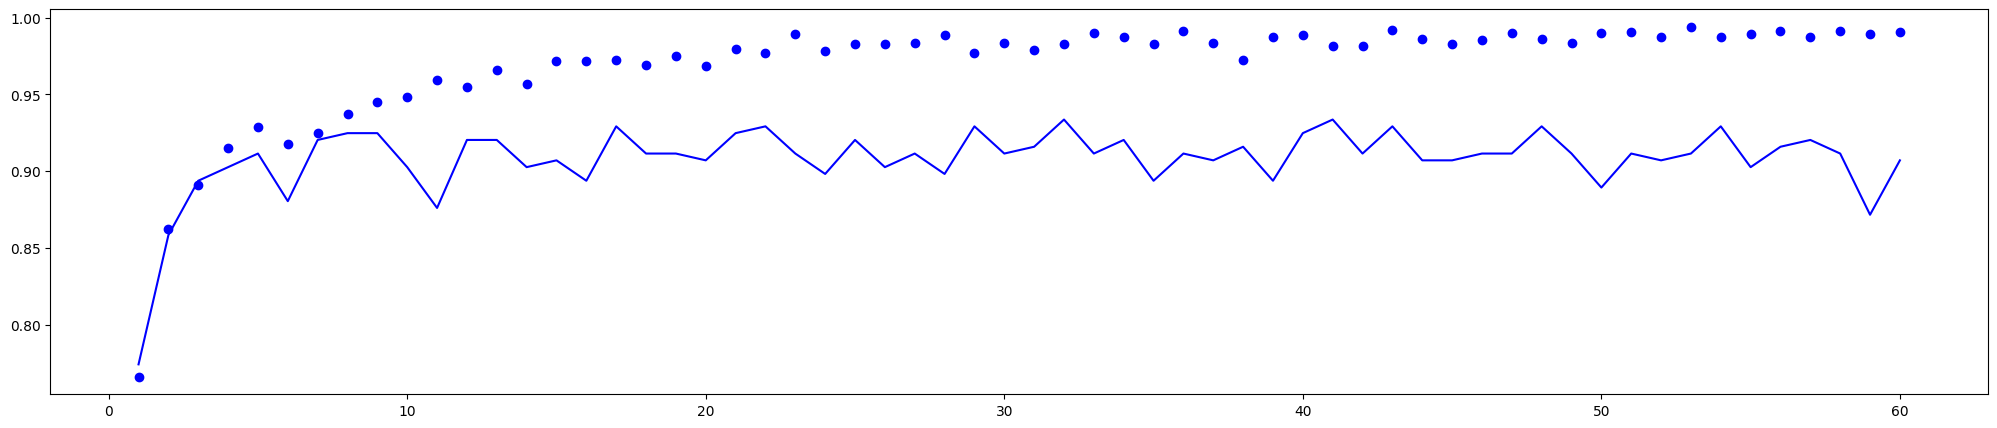

In [284]:
history3 = {k: [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in vs] for k, vs in history3.items()}
plot_accuracy_from_history(history3)
print(history3['accuracy'])